In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import csv
import ast


from datetime import datetime
from datetime import timedelta
from pandas.plotting import register_matplotlib_converters
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARMA
register_matplotlib_converters()
from time import time
from tqdm import tqdm
sns.set_theme()
from collections import defaultdict
from mpl_toolkits.mplot3d import Axes3D


In [3]:
expanded_census_data = pd.read_csv('expanded_census_data.csv')
solar_data = pd.read_csv('solar_data.csv')
gas_meter_data = pd.read_csv('gas_meter_data.csv')
summary_census_data = pd.read_csv('summary_census_data.csv')
# meter_data = pd.read_csv('meter_data.csv', engine="pyarrow")
# gas_meter_data = pd.read_csv('gas_meter_data.csv')


In [4]:
print('HEAD', expanded_census_data.head())
print('INFO', expanded_census_data.info())
print('DESCRIPTION', expanded_census_data.describe())

HEAD       Block  House ID  Median Income  Employment Rate  Total Population  \
0  812103-1  b1eb5eb2          52154              565              1104   
1  812103-1  b1eb5eb2          52154              565              1104   
2  812103-1  70e974b0          52154              565              1104   
3  812103-1  70e974b0          52154              565              1104   
4  812103-1  ebb6aac2          52154              565              1104   

   Poverty  Total Housing Units  Renter-Occupied Units  \
0       85                  435                    189   
1       85                  435                    189   
2       85                  435                    189   
3       85                  435                    189   
4       85                  435                    189   

   Electric Heating Units  Gas Heating Units  ...  2000to2009  1990to1999  \
0                     122                136  ...           0          38   
1                     122                

In [5]:
print('HEAD', solar_data.head())
print('INFO', solar_data.info())
print('DESCRIPTION', solar_data.describe())

path_name = './Figure/'
png_path_name = './Figure/png/'

HEAD    house_id  device_id  gas_meter_id        lat       long  \
0  b1eb5eb2   83771758           NaN  42.191697 -72.613522   
1  b1eb5eb2   69525019           NaN  42.191697 -72.613522   
2  a90ea0b3    5827516    54363558.0  42.211167 -72.621543   
3  049bf03c   83770216    54459969.0  42.211157 -72.621317   
4  b2dc9fbe   56976532           NaN  42.210828 -72.621242   

   hours_of_sunlight_per_year  sq_ft_available_for_solar_panels  
0                        1404                              3207  
1                           0                                 0  
2                        1488                              1180  
3                        1504                              1163  
4                        1383                               846  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17052 entries, 0 to 17051
Data columns (total 7 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  

In [6]:
# print('HEAD', meter_data.head())
# print('INFO', meter_data.info())
# print('DESCRIPTION', meter_data.describe())

In [7]:
print('HEAD', gas_meter_data.head())
print('INFO', gas_meter_data.info())
print('DESCRIPTION', gas_meter_data.describe())

HEAD    house_id  gas_meter_id  2020-01-01 00:00:00  2020-01-01 01:00:00  \
0  a90ea0b3      54363558                 0.00                 0.00   
1  049bf03c      54459969                 0.00                 0.00   
2  569aaf4b      40488619                 2.40                 2.64   
3  5edb8c2b      94746136                 0.96                 1.68   
4  0a4bda96      56809534                 0.00                 0.00   

   2020-01-01 02:00:00  2020-01-01 03:00:00  2020-01-01 04:00:00  \
0                 0.00                  0.0                 0.00   
1                 0.00                  0.0                 0.00   
2                 2.40                  2.4                 2.16   
3                 0.72                  0.0                 0.00   
4                 0.00                  0.0                 0.00   

   2020-01-01 05:00:00  2020-01-01 06:00:00  2020-01-01 07:00:00  ...  \
0                  0.0                 0.00                  0.0  ...   
1            

In [8]:
merged_solar_data = pd.merge(solar_data, expanded_census_data,
                       left_on='house_id', right_on='House ID', how='left')

# Optionally, drop the extra 'House ID' column if it's no longer needed
merged_solar_data.drop('House ID', axis=1, inplace=True)

# Check if there are any rows with missing 'Block Category' values
print("Missing 'Block Category' values:", merged_solar_data['Block Category'].isna().sum())

# Handle rows with missing 'Block Category' values if necessary
# For example, you can fill missing values with 'Unknown' or a similar placeholder
# merged_solar_data['Block Category'].fillna('Unknown', inplace=True)

# Display the head of the merged dataframe to verify
print(merged_solar_data.head())
merged_solar_data.info()
merged_solar_data.drop_duplicates(subset=['house_id', 'device_id'], inplace=True)

Missing 'Block Category' values: 152
   house_id  device_id  gas_meter_id        lat       long  \
0  b1eb5eb2   83771758           NaN  42.191697 -72.613522   
1  b1eb5eb2   83771758           NaN  42.191697 -72.613522   
2  b1eb5eb2   69525019           NaN  42.191697 -72.613522   
3  b1eb5eb2   69525019           NaN  42.191697 -72.613522   
4  a90ea0b3    5827516    54363558.0  42.211167 -72.621543   

   hours_of_sunlight_per_year  sq_ft_available_for_solar_panels     Block  \
0                        1404                              3207  812103-1   
1                        1404                              3207  812103-1   
2                           0                                 0  812103-1   
3                           0                                 0  812103-1   
4                        1488                              1180  811800-3   

   Median Income  Employment Rate  ...  2000to2009  1990to1999  1980to1989  \
0        52154.0            565.0  ...         0.

In [9]:
# Adjusted merge to only include 'Block Category' from expanded_census_data
merged_gas_meter_data = pd.merge(gas_meter_data, expanded_census_data[['House ID', 'Block', 'Block Category']],
                                 left_on='house_id', right_on='House ID', how='left')

# Optionally, drop the extra 'House ID' column if it's no longer needed
merged_gas_meter_data.drop('House ID', axis=1, inplace=True)

# Check if there are any rows with missing 'Block Category' values
print("Missing 'Block' values:", merged_gas_meter_data['Block'].isna().sum())
print("Missing 'Block Category' values:", merged_gas_meter_data['Block Category'].isna().sum())

# Handle rows with missing 'Block Category' values if necessary
# For example, you can fill missing values with 'Unknown' or a similar placeholder
merged_gas_meter_data['Block'].fillna('Unknown', inplace=True)
merged_gas_meter_data['Block Category'].fillna('Unknown', inplace=True)

# Define the order of columns, placing 'Block' and 'Block Category' first
column_order = ['Block', 'Block Category'] + [col for col in merged_gas_meter_data.columns if col not in ['Block', 'Block Category']]

# Reorder the columns in the DataFrame
merged_gas_meter_data = merged_gas_meter_data[column_order]

# Now you can proceed to save the modified DataFrame to CSV
merged_gas_meter_data.to_csv('merged_gas_meter_data.csv', index=False)

# Display the head of the rearranged DataFrame to verify the order
print(merged_gas_meter_data.head())


Missing 'Block' values: 0
Missing 'Block Category' values: 0
      Block Block Category  house_id  gas_meter_id  2020-01-01 00:00:00  \
0  811800-3         Median  a90ea0b3      54363558                 0.00   
1  811800-3         Median  049bf03c      54459969                 0.00   
2  812001-3      High-Rent  569aaf4b      40488619                 2.40   
3  812101-1       Low-Rent  5edb8c2b      94746136                 0.96   
4  811400-1      High-Rent  0a4bda96      56809534                 0.00   

   2020-01-01 01:00:00  2020-01-01 02:00:00  2020-01-01 03:00:00  \
0                 0.00                 0.00                  0.0   
1                 0.00                 0.00                  0.0   
2                 2.64                 2.40                  2.4   
3                 1.68                 0.72                  0.0   
4                 0.00                 0.00                  0.0   

   2020-01-01 04:00:00  2020-01-01 05:00:00  ...  2020-12-31 14:00:00  \
0     

### Plotting Solar Panel Data based on (Square Foot, Annual Sunlight Hours) by Rent Category

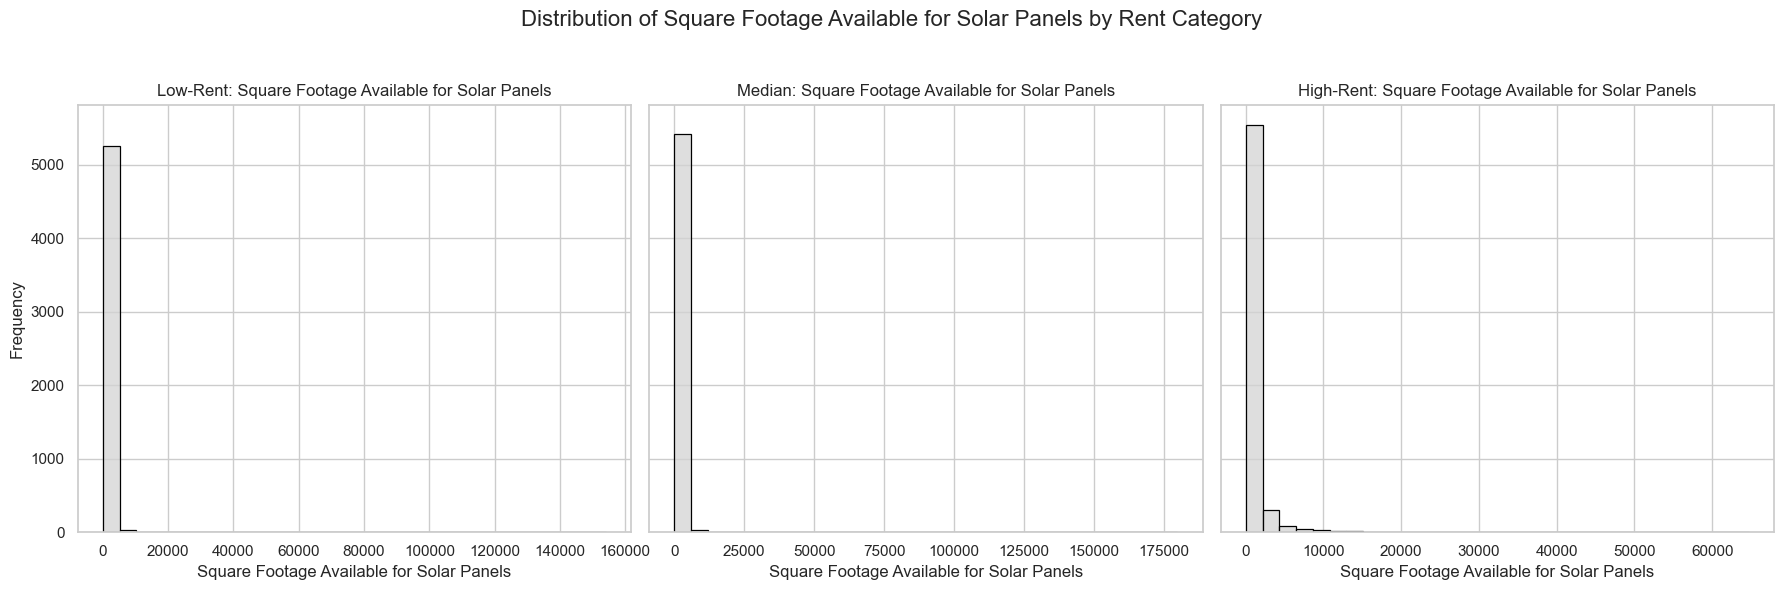

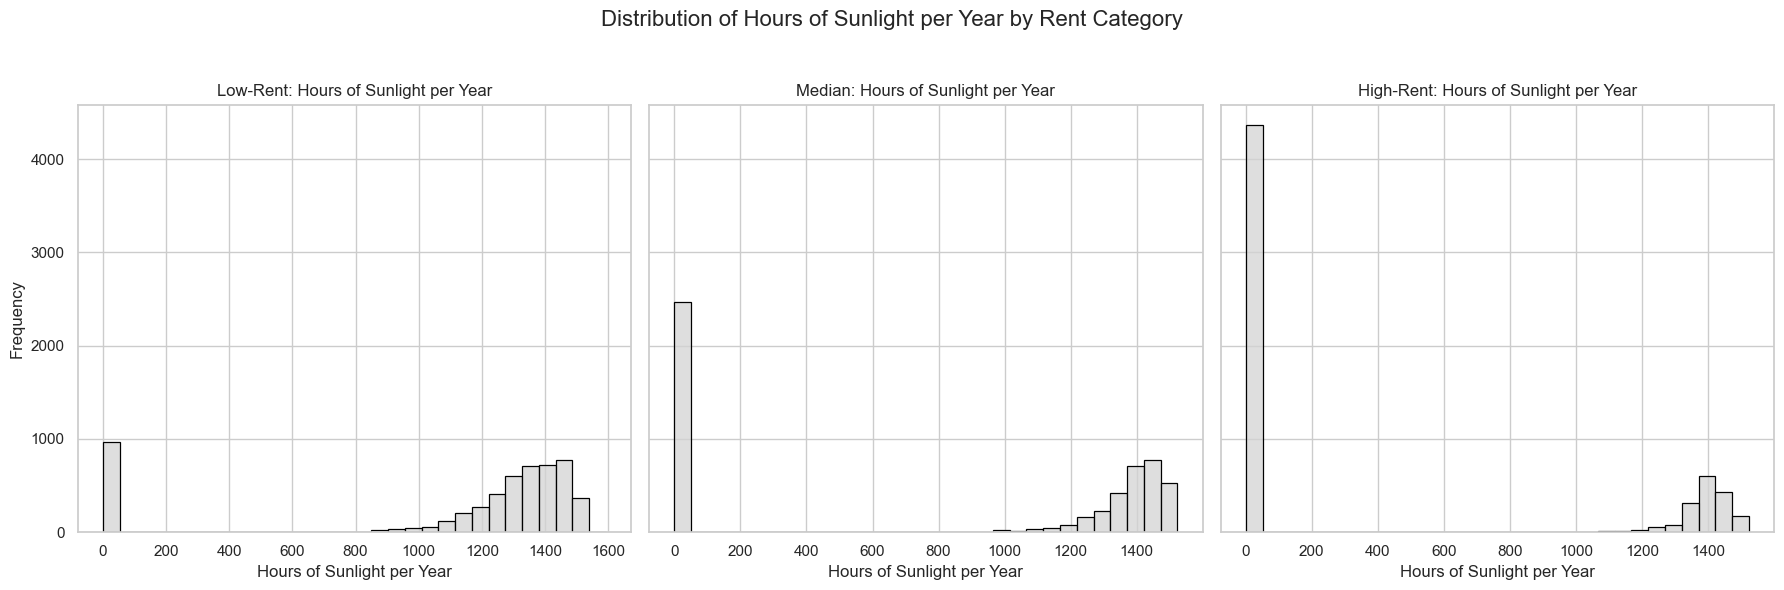

In [10]:
# Set the aesthetic style of the plots
sns.set(style="whitegrid")

# Data categories
categories = ['Low-Rent', 'Median', 'High-Rent']
data_columns = ['sq_ft_available_for_solar_panels', 'hours_of_sunlight_per_year']
titles = ['Square Footage Available for Solar Panels', 'Hours of Sunlight per Year']

# Plot for Square Footage Available for Solar Panels
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)
fig.suptitle('Distribution of Square Footage Available for Solar Panels by Rent Category', fontsize=16)



for i, category in enumerate(categories):
    category_data = merged_solar_data[merged_solar_data['Block Category'] == category]
    sns.histplot(category_data['sq_ft_available_for_solar_panels'], ax=axes[i], bins=30, kde=False, color='lightgrey', edgecolor='black')
    axes[i].set_title(f'{category}: {titles[0]}')
    axes[i].set_xlabel(titles[0])
    axes[i].set_ylabel('Frequency')


plt.tight_layout(rect=[0, 0, 1, 0.95])

# Save the plots as SVG & PNG files
plt.savefig(path_name + 'solar_panels_sqf_distribution.svg', format='svg', bbox_inches='tight')
plt.savefig(png_path_name + 'solar_panels_sqf_distribution.png', format='png', bbox_inches='tight')

plt.show()

# Plot for Hours of Sunlight per Year
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)
fig.suptitle('Distribution of Hours of Sunlight per Year by Rent Category', fontsize=16)

for i, category in enumerate(categories):
    category_data = merged_solar_data[merged_solar_data['Block Category'] == category]
    sns.histplot(category_data['hours_of_sunlight_per_year'], ax=axes[i], bins=30, kde=False, color='lightgrey', edgecolor='black')
    axes[i].set_title(f'{category}: {titles[1]}')
    axes[i].set_xlabel(titles[1])
    axes[i].set_ylabel('Frequency')


plt.tight_layout(rect=[0, 0, 1, 0.95])


# Save the plots as SVG & PNG files
plt.savefig(path_name + 'solar_panels_sun_distribution.svg', format='svg', bbox_inches='tight')
plt.savefig(png_path_name + 'solar_panels_sun_distribution.png', format='png', bbox_inches='tight')

# Show the plots
plt.show()


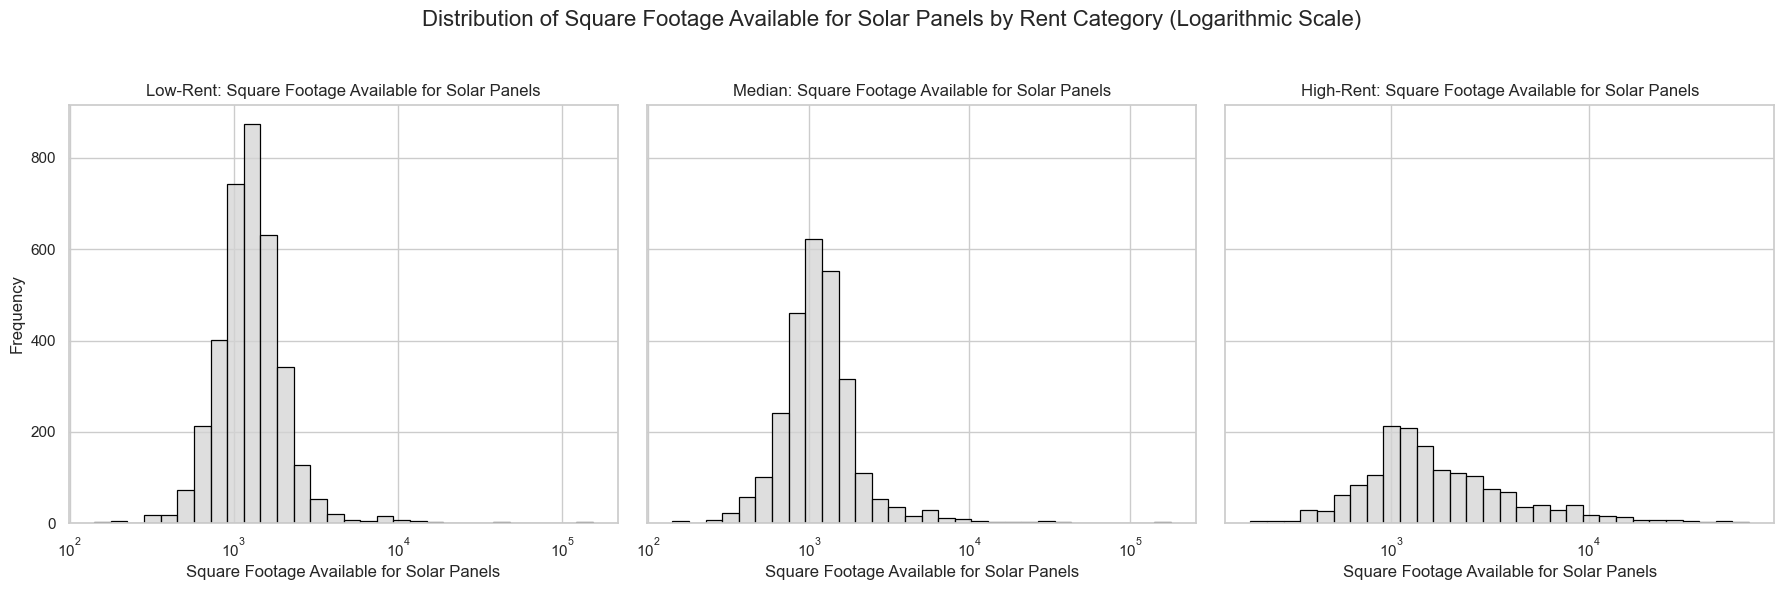

In [11]:
# Set the aesthetic style of the plots
sns.set(style="whitegrid")

# Data categories
categories = ['Low-Rent', 'Median', 'High-Rent']
title = 'Square Footage Available for Solar Panels'

# Plot for Square Footage Available for Solar Panels (Logarithmic Scale)
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)
fig.suptitle('Distribution of Square Footage Available for Solar Panels by Rent Category (Logarithmic Scale)', fontsize=16)

for i, category in enumerate(categories):
    category_data = merged_solar_data[(merged_solar_data['Block Category'] == category) & (merged_solar_data['sq_ft_available_for_solar_panels'] > 0)]
    sns.histplot(category_data['sq_ft_available_for_solar_panels'], ax=axes[i], bins=30, kde=False, color='lightgrey', edgecolor='black', log_scale=(True, False))
    axes[i].set_title(f'{category}: {title}')
    axes[i].set_xlabel(title)
    axes[i].set_ylabel('Frequency')

plt.tight_layout(rect=[0, 0, 1, 0.95])

# Save the plots as SVG & PNG files
plt.savefig(path_name + 'solar_panels_sqf_distribution_log_scale.svg', format='svg', bbox_inches='tight')
plt.savefig(png_path_name + 'solar_panels_sqf_distribution_log_scale.png', format='png', bbox_inches='tight')

plt.show()


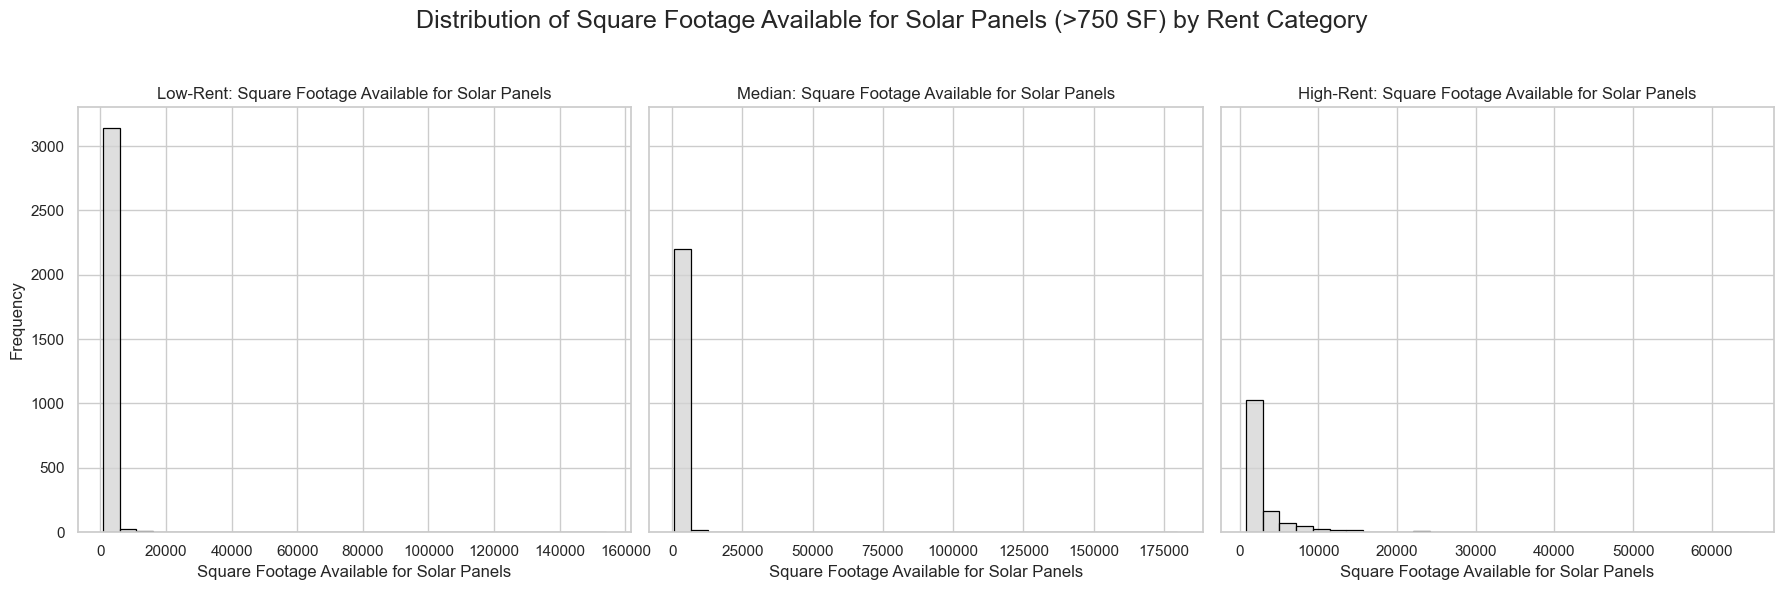

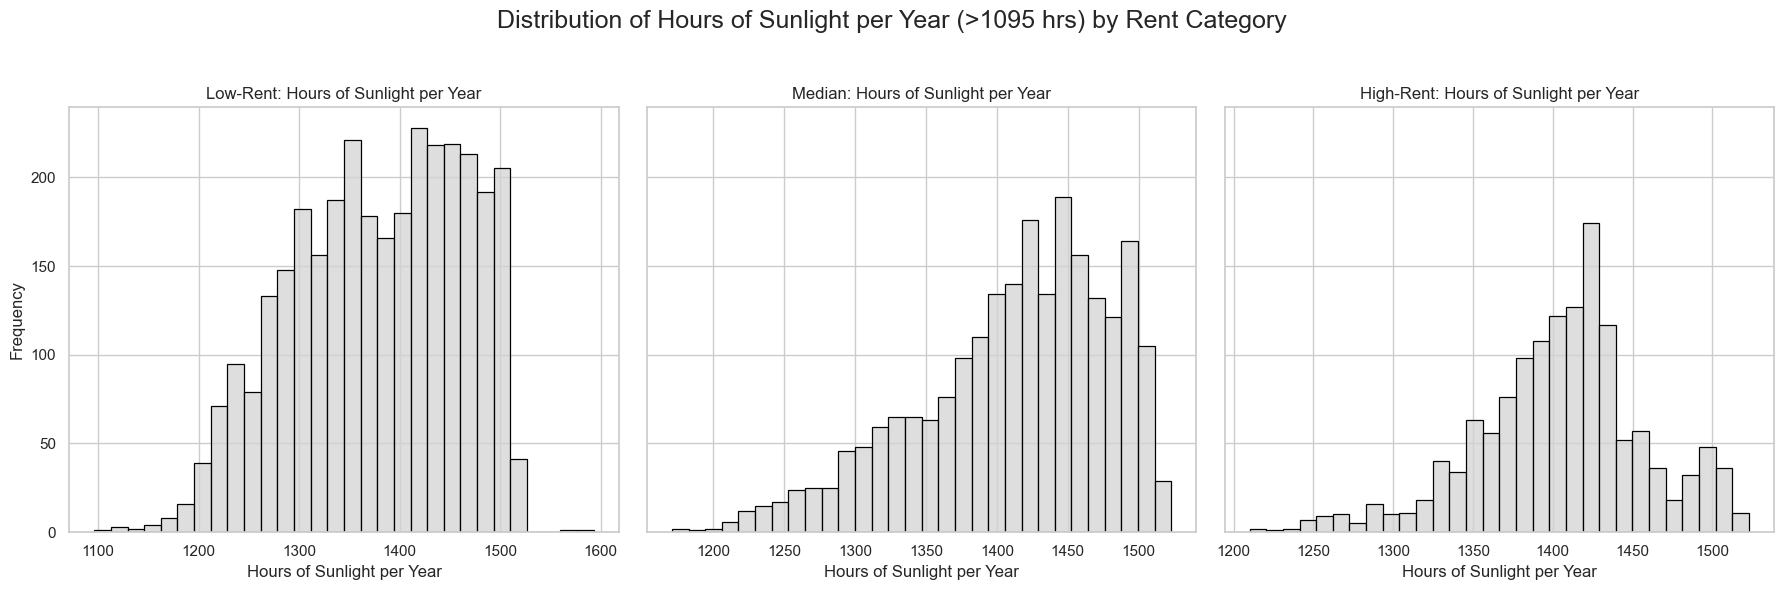

<class 'pandas.core.frame.DataFrame'>
Index: 6889 entries, 0 to 18585
Data columns (total 30 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   house_id                          6889 non-null   object 
 1   device_id                         6889 non-null   int64  
 2   gas_meter_id                      4958 non-null   float64
 3   lat                               6889 non-null   float64
 4   long                              6889 non-null   float64
 5   hours_of_sunlight_per_year        6889 non-null   int64  
 6   sq_ft_available_for_solar_panels  6889 non-null   int64  
 7   Block                             6822 non-null   object 
 8   Median Income                     6822 non-null   float64
 9   Employment Rate                   6822 non-null   float64
 10  Total Population                  6822 non-null   float64
 11  Poverty                           6822 non-null   float64
 12  Total Hous

In [12]:
# Filter the data
non_zero_merged_data = merged_solar_data[(merged_solar_data['sq_ft_available_for_solar_panels'] > 750) & 
                                         (merged_solar_data['hours_of_sunlight_per_year'] > 1095)]

# Set the aesthetic style of the plots
sns.set(style="whitegrid")

# Data categories
categories = ['Low-Rent', 'Median', 'High-Rent']
titles = ['Square Footage Available for Solar Panels', 'Hours of Sunlight per Year']

# Plot for Square Footage Available for Solar Panels
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)
fig.suptitle('Distribution of Square Footage Available for Solar Panels (>750 SF) by Rent Category', fontsize=18)

for i, category in enumerate(categories):
    category_data = non_zero_merged_data[non_zero_merged_data['Block Category'] == category]
    sns.histplot(category_data['sq_ft_available_for_solar_panels'], ax=axes[i], bins=30, kde=False, color='lightgrey', edgecolor='black')
    axes[i].set_title(f'{category}: {titles[0]}')
    axes[i].set_xlabel(titles[0])
    axes[i].set_ylabel('Frequency')

plt.tight_layout(rect=[0, 0, 1, 0.95])

# Save as SVG & PNG files
plt.savefig(path_name + 'solar_panels_sqf_distribution_filtered.svg', format='svg', bbox_inches='tight')
plt.savefig(png_path_name + 'solar_panels_sqf_distribution_filtered.png', format='png', bbox_inches='tight')

plt.show()

# Plot for Hours of Sunlight per Year
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)
fig.suptitle('Distribution of Hours of Sunlight per Year (>1095 hrs) by Rent Category', fontsize=18)

for i, category in enumerate(categories):
    category_data = non_zero_merged_data[non_zero_merged_data['Block Category'] == category]
    sns.histplot(category_data['hours_of_sunlight_per_year'], ax=axes[i], bins=30, kde=False, color='lightgrey', edgecolor='black')
    axes[i].set_title(f'{category}: {titles[1]}')
    axes[i].set_xlabel(titles[1])
    axes[i].set_ylabel('Frequency')

plt.tight_layout(rect=[0, 0, 1, 0.95])

# Save as SVG & PNG files
plt.savefig(path_name + 'solar_panels_sun_distribution_filtered.svg', format='svg', bbox_inches='tight')
plt.savefig(png_path_name + 'solar_panels_sun_distribution_filtered.png', format='png', bbox_inches='tight')

plt.show()

print(non_zero_merged_data.info())


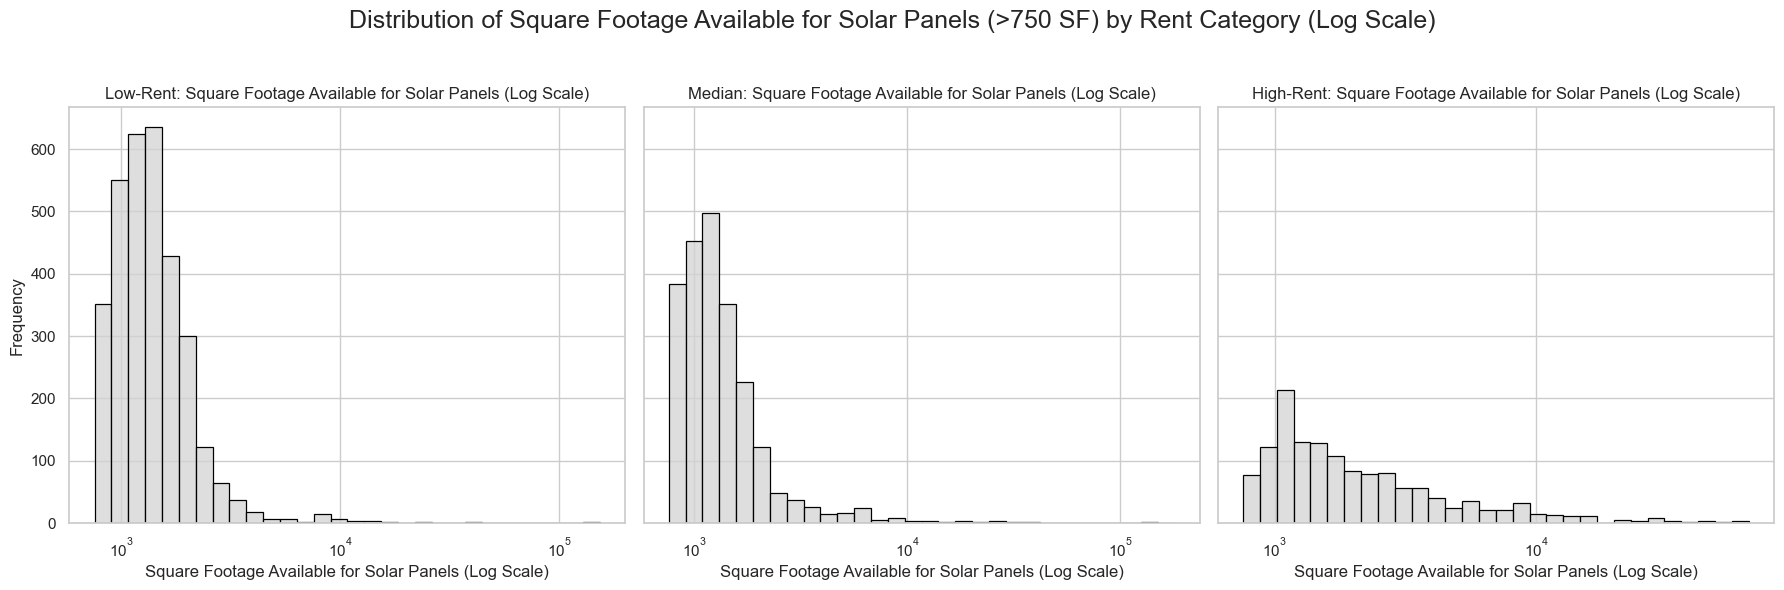

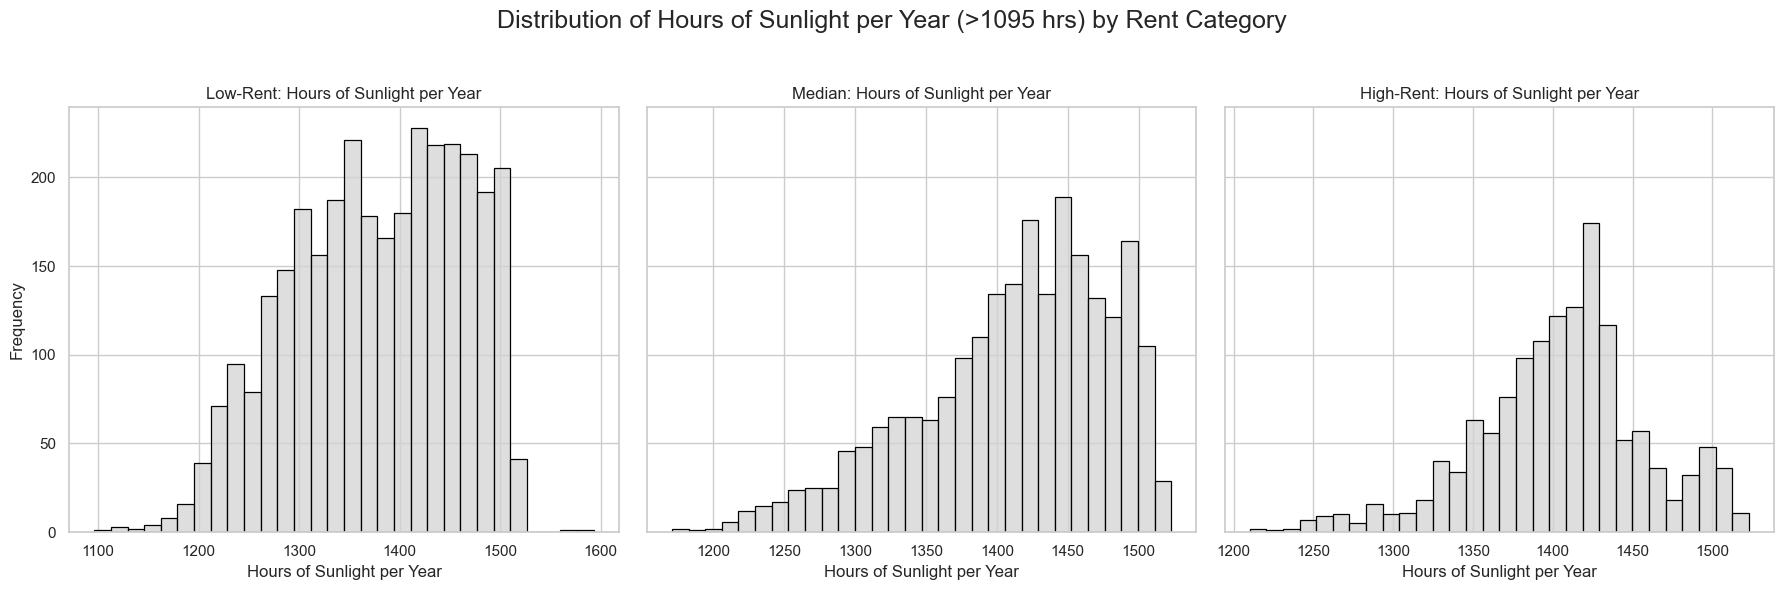

<class 'pandas.core.frame.DataFrame'>
Index: 6889 entries, 0 to 18585
Data columns (total 30 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   house_id                          6889 non-null   object 
 1   device_id                         6889 non-null   int64  
 2   gas_meter_id                      4958 non-null   float64
 3   lat                               6889 non-null   float64
 4   long                              6889 non-null   float64
 5   hours_of_sunlight_per_year        6889 non-null   int64  
 6   sq_ft_available_for_solar_panels  6889 non-null   int64  
 7   Block                             6822 non-null   object 
 8   Median Income                     6822 non-null   float64
 9   Employment Rate                   6822 non-null   float64
 10  Total Population                  6822 non-null   float64
 11  Poverty                           6822 non-null   float64
 12  Total Hous

In [13]:
# Set the aesthetic style of the plots
sns.set(style="whitegrid")

# Data categories
categories = ['Low-Rent', 'Median', 'High-Rent']
titles = ['Square Footage Available for Solar Panels (Log Scale)', 'Hours of Sunlight per Year']

# Plot for Square Footage Available for Solar Panels on Log Scale
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)
fig.suptitle('Distribution of Square Footage Available for Solar Panels (>750 SF) by Rent Category (Log Scale)', fontsize=18)

for i, category in enumerate(categories):
    category_data = non_zero_merged_data[non_zero_merged_data['Block Category'] == category]
    sns.histplot(category_data['sq_ft_available_for_solar_panels'], ax=axes[i], bins=30, kde=False, color='lightgrey', edgecolor='black', log_scale=(True, False))
    axes[i].set_title(f'{category}: {titles[0]}')
    axes[i].set_xlabel(titles[0])
    axes[i].set_ylabel('Frequency')

plt.tight_layout(rect=[0, 0, 1, 0.95])


# Save as SVG & PNG files
plt.savefig(path_name + 'solar_panels_sqf_distribution_filtered_log_scale.svg', format='svg', bbox_inches='tight')
plt.savefig(png_path_name + 'solar_panels_sqf_distribution_filtered_log_scale.png', format='png', bbox_inches='tight')


plt.show()

# Plot for Hours of Sunlight per Year
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)
fig.suptitle('Distribution of Hours of Sunlight per Year (>1095 hrs) by Rent Category', fontsize=18)

for i, category in enumerate(categories):
    category_data = non_zero_merged_data[non_zero_merged_data['Block Category'] == category]
    sns.histplot(category_data['hours_of_sunlight_per_year'], ax=axes[i], bins=30, kde=False, color='lightgrey', edgecolor='black')
    axes[i].set_title(f'{category}: {titles[1]}')
    axes[i].set_xlabel(titles[1])
    axes[i].set_ylabel('Frequency')

plt.tight_layout(rect=[0, 0, 1, 0.95])


# Save as SVG & PNG files
plt.savefig(path_name + 'solar_panels_sun_distribution_filtered.svg', format='svg', bbox_inches='tight')
plt.savefig(png_path_name + 'solar_panels_sun_distribution_filtered.png', format='png', bbox_inches='tight')

plt.show()

print(non_zero_merged_data.info())


In [14]:
# Assuming 'merged_gas_meter_data' is already filtered and contains 'Block Category' along with 'sq_ft_available_for_solar_panels' and 'hours_of_sunlight_per_year'

# Filter the DataFrame for entries that meet the solar panel and sunlight requirements
filtered_data = merged_solar_data[
    (merged_solar_data['sq_ft_available_for_solar_panels'] > 750) &
    (merged_solar_data['hours_of_sunlight_per_year'] > 1095)
]

# Data categories
categories = ['Low-Rent', 'Median', 'High-Rent']
statistics = {}

# Calculating statistics for each category
for category in categories:
    category_data = filtered_data[filtered_data['Block Category'] == category]
    sq_ft_stats = category_data['sq_ft_available_for_solar_panels'].agg({
        'min': 'min',
        'max': 'max',
        'median': 'median',
        'mean': 'mean',
        'mode': lambda x: x.mode().iloc[0],
        '25th percentile': lambda x: x.quantile(0.25),
        '75th percentile': lambda x: x.quantile(0.75)
    })
    sunlight_stats = category_data['hours_of_sunlight_per_year'].agg({
        'min': 'min',
        'max': 'max',
        'median': 'median',
        'mean': 'mean',
        'mode': lambda x: x.mode().iloc[0],
        '25th percentile': lambda x: x.quantile(0.25),
        '75th percentile': lambda x: x.quantile(0.75)
    })
    
    # Store the statistics in a dictionary
    statistics[category] = {
        'Minimum Square Foot': sq_ft_stats['min'],
        'Maximum Square Foot': sq_ft_stats['max'],
        'Median Square Foot': sq_ft_stats['median'],
        'Mean Square Foot': sq_ft_stats['mean'],
        'Mode Square Foot': sq_ft_stats['mode'],
        '25th Percentile Square Foot': sq_ft_stats['25th percentile'],
        '75th Percentile Square Foot': sq_ft_stats['75th percentile'],
        'Minimum Sunlight Hours': sunlight_stats['min'],
        'Maximum Sunlight Hours': sunlight_stats['max'],
        'Median Sunlight Hours': sunlight_stats['median'],
        'Mean Sunlight Hours': sunlight_stats['mean'],
        'Mode Sunlight Hours': sunlight_stats['mode'],
        '25th Percentile Sunlight Hours': sunlight_stats['25th percentile'],
        '75th Percentile Sunlight Hours': sunlight_stats['75th percentile']
    }

# Convert the statistics dictionary to a DataFrame for display
stats_df = pd.DataFrame(statistics).T
stats_df.rename(columns={lambda x: x.mode().iloc[0]: 'Mode'}, inplace=True)
stats_df


,Minimum Square Foot,Maximum Square Foot,Median Square Foot,Mean Square Foot,Mode Square Foot,25th Percentile Square Foot,75th Percentile Square Foot,Minimum Sunlight Hours,Maximum Sunlight Hours,Median Sunlight Hours,Mean Sunlight Hours,Mode Sunlight Hours,25th Percentile Sunlight Hours,75th Percentile Sunlight Hours
Low-Rent,758.0,154108.0,1321.0,1735.561971,1251.0,1057.0,1691.0,1096.0,1593.0,1384.0,1378.475369,1356.0,1313.0,1449.0
Median,758.0,179848.0,1233.0,1852.422063,1251.0,987.0,1568.0,1171.0,1523.0,1422.0,1411.857972,1446.0,1372.0,1463.0
High-Rent,758.0,64712.0,1639.0,3357.632521,1039.0,1145.0,3083.0,1210.0,1523.0,1409.0,1405.063754,1432.0,1376.0,1434.0


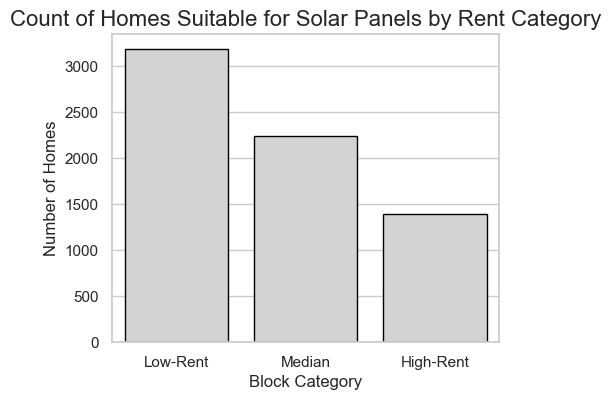

  Block Category  Number of Homes
0       Low-Rent             3187
1         Median             2239
2      High-Rent             1396


In [15]:
# Group by 'Block Category' and count the number of homes
category_counts = non_zero_merged_data['Block Category'].value_counts().reset_index()
category_counts.columns = ['Block Category', 'Number of Homes']

# Setting the aesthetic style of the plots
sns.set(style="whitegrid")

# Create a bar chart
plt.figure(figsize=(5, 4))
bar = sns.barplot(x='Block Category', y='Number of Homes', data=category_counts, color='lightgrey', edgecolor='black')
plt.title('Count of Homes Suitable for Solar Panels by Rent Category', fontsize=16)
plt.xlabel('Block Category')
plt.ylabel('Number of Homes')


# Save as SVG & PNG files
plt.savefig(path_name + 'solar_panels_home_count.svg', format='svg', bbox_inches='tight')
plt.savefig(png_path_name + 'solar_panels_home_count.png', format='png', bbox_inches='tight')

plt.show()

print(category_counts)

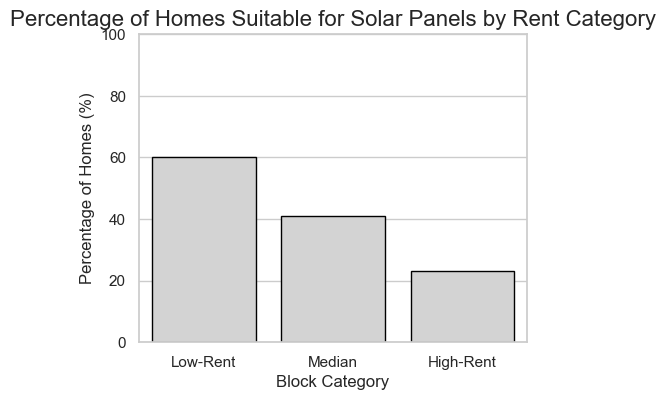

  Block Category  Percentage of Homes
1       Low-Rent            60.075401
2         Median            40.827863
0      High-Rent            22.986992


In [16]:
# Filter data for homes with more than 750 sq ft of solar panels and more than 1095 hours of sunlight per year
suitable_homes = merged_solar_data[(merged_solar_data['sq_ft_available_for_solar_panels'] > 750) & 
                             (merged_solar_data['hours_of_sunlight_per_year'] > 1095)]

# Count the number of suitable homes per category
suitable_counts = suitable_homes['Block Category'].value_counts().rename('Suitable Homes')

# Count the total number of homes per category
total_counts = merged_solar_data['Block Category'].value_counts().rename('Total Homes')

# Calculate the percentages
percentages = (suitable_counts / total_counts * 100).reset_index()
percentages.columns = ['Block Category', 'Percentage of Homes']

# Define the order of categories
category_order = ['Low-Rent', 'Median', 'High-Rent']
percentages['Block Category'] = pd.Categorical(percentages['Block Category'], categories=category_order, ordered=True)

# Sort the DataFrame by the ordered categorical
percentages = percentages.sort_values('Block Category')

# Setting the aesthetic style of the plots
sns.set(style="whitegrid")

# Create a bar chart
plt.figure(figsize=(5, 4))
bar = sns.barplot(x='Block Category', y='Percentage of Homes', data=percentages, color='lightgrey', edgecolor='black')
plt.title('Percentage of Homes Suitable for Solar Panels by Rent Category', fontsize=16)
plt.xlabel('Block Category')
plt.ylabel('Percentage of Homes (%)')
plt.ylim(0, 100)  # Optionally set the y-axis limits to 0-100% for clarity


# Save as SVG & PNG files
plt.savefig(path_name + 'solar_panels_home_percentage.svg', format='svg', bbox_inches='tight')
plt.savefig(png_path_name + 'solar_panels_home_percentage.png', format='png', bbox_inches='tight')

plt.show()

print(percentages)

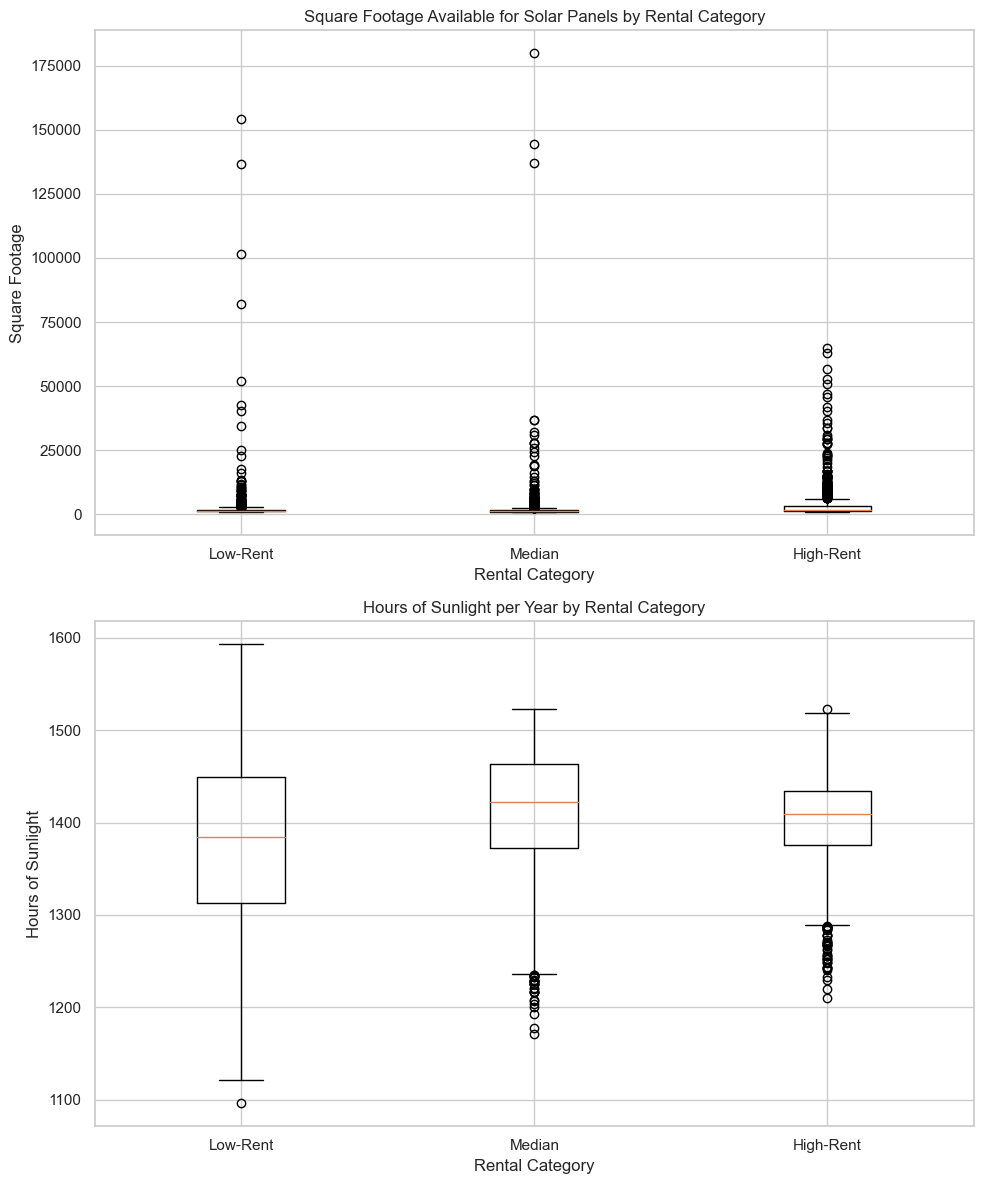

In [17]:
# Assuming 'filtered_data' has the correct data filtered and includes the 'Block Category'
# Let's plot the distribution of 'sq_ft_available_for_solar_panels' and 'hours_of_sunlight_per_year' for each category

fig, ax = plt.subplots(2, 1, figsize=(10, 12))  # Creates a figure with two subplots

# Box plot for square footage available for solar panels
ax[0].boxplot([filtered_data.loc[filtered_data['Block Category'] == category, 'sq_ft_available_for_solar_panels'] for category in categories],
              labels=categories)
ax[0].set_title('Square Footage Available for Solar Panels by Rental Category')
ax[0].set_ylabel('Square Footage')
ax[0].set_xlabel('Rental Category')

# Box plot for hours of sunlight per year
ax[1].boxplot([filtered_data.loc[filtered_data['Block Category'] == category, 'hours_of_sunlight_per_year'] for category in categories],
              labels=categories)
ax[1].set_title('Hours of Sunlight per Year by Rental Category')
ax[1].set_ylabel('Hours of Sunlight')
ax[1].set_xlabel('Rental Category')

plt.tight_layout()  # Adjusts plot to ensure everything fits without overlap

# Save the plot as SVG & PNG files
plt.savefig(path_name + 'solar_panels_boxplot.svg', format='svg', bbox_inches='tight')
plt.savefig(png_path_name + 'solar_panels_boxplot.png', format='png', bbox_inches='tight')

plt.show()  # Displays the plot


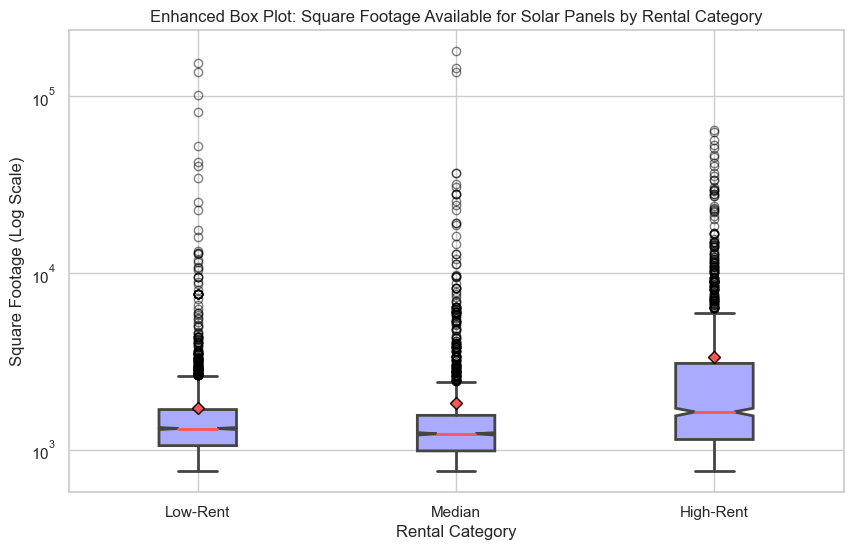

In [18]:

# Assuming 'filtered_data' and 'categories' are defined as before

fig, ax = plt.subplots(figsize=(10, 6))

# Create a list of data for plotting
data_to_plot = [filtered_data.loc[filtered_data['Block Category'] == category, 'sq_ft_available_for_solar_panels'] for category in categories]

# Plotting with custom adjustments
bp = ax.boxplot(data_to_plot, labels=categories, notch=True, patch_artist=True, showmeans=True)

# Change outline color, fill color and linewidth of the boxes
for box in bp['boxes']:
    # Change outline and fill color
    box.set(color='#444444', linewidth=2)
    box.set(facecolor='#AAAAFF')

# Change color and linewidth of the whiskers
for whisker in bp['whiskers']:
    whisker.set(color='#444444', linewidth=2)

# Change color and linewidth of the caps
for cap in bp['caps']:
    cap.set(color='#444444', linewidth=2)

# Change color and linewidth of the medians
for median in bp['medians']:
    median.set(color='#FF5555', linewidth=2)

# Change the style of fliers and their fill
for flier in bp['fliers']:
    flier.set(marker='o', color='#e7298a', alpha=0.5)

# Change the mean elements
for mean in bp['means']:
    mean.set(marker='D', markeredgecolor='black', markerfacecolor='#FF5555')

# Adding a logarithmic scale
ax.set_yscale('log')

ax.set_title('Enhanced Box Plot: Square Footage Available for Solar Panels by Rental Category')
ax.set_ylabel('Square Footage (Log Scale)')
ax.set_xlabel('Rental Category')

plt.grid(True)

# Save as SVG & PNG files
plt.savefig(path_name + 'solar_panels_boxplot_enhanced.svg', format='svg', bbox_inches='tight')
plt.savefig(png_path_name + 'solar_panels_boxplot_enhanced.png', format='png', bbox_inches='tight')


plt.show()


### Plotting Gas Meter Data (Aggregated Gas Usage) by Rent Category

In [19]:
# Load your data
merged_gas_meter_data = pd.read_csv('merged_gas_meter_data.csv')

# Identify time series columns (assuming they are all the columns after 'gas_meter_id')
time_series_columns = merged_gas_meter_data.columns[merged_gas_meter_data.columns.get_loc('2020-01-01 00:00:00'):]

# Sum the time series data for each row
merged_gas_meter_data['Total Gas Usage'] = merged_gas_meter_data[time_series_columns].sum(axis=1)

# Specify the desired order for 'Block Category'
category_order = ['Low-Rent', 'Median', 'High-Rent', 'Unknown']
merged_gas_meter_data['Block Category'] = pd.Categorical(merged_gas_meter_data['Block Category'], categories=category_order, ordered=True)

# Aggregate this total by 'Block Category'
total_gas_usage_by_block = merged_gas_meter_data.groupby('Block Category')['Total Gas Usage'].sum()

print(total_gas_usage_by_block)


Block Category
Low-Rent     24871437.36
Median       19332929.16
High-Rent    16344775.92
Unknown             0.00
Name: Total Gas Usage, dtype: float64


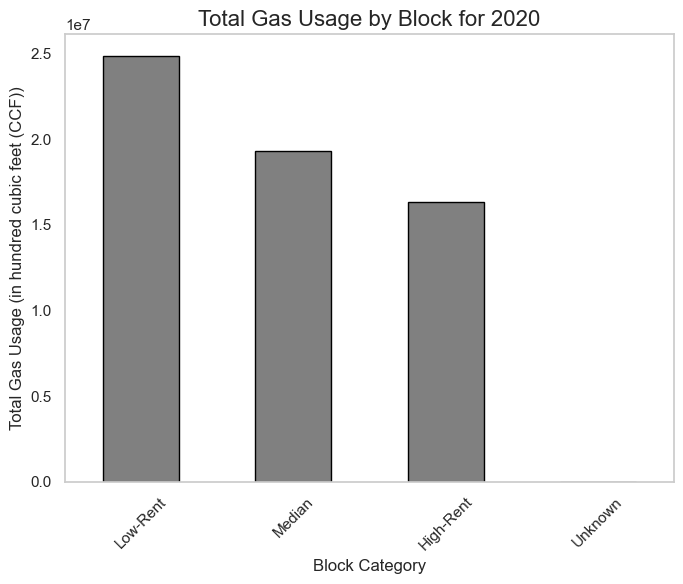

In [20]:
# Plotting the results for total gas usage by block category
plt.figure(figsize=(7, 6))
total_gas_usage_by_block.plot(kind='bar', color='grey', edgecolor='black')
plt.title('Total Gas Usage by Block for 2020', fontsize=16)  # Increased title size
plt.xlabel('Block Category')
plt.ylabel('Total Gas Usage (in hundred cubic feet (CCF))')
plt.xticks(rotation=45)
plt.grid(False)  # Remove gridlines
plt.tight_layout()

# Save as SVG & PNG files
plt.savefig(path_name + 'total_gas_usage_by_block.svg', format='svg', bbox_inches='tight')
plt.savefig(png_path_name + 'total_gas_usage_by_block.png', format='png', bbox_inches='tight')

plt.show()

In [21]:
def ccf_to_kwh(ccf):
    return ccf * 100 * 0.29307107

In [22]:
# Assuming summary_census_data and total_gas_usage_by_block are available
# Total Population by Block Category
population_density = summary_census_data.groupby('Block Category')['Total Population'].sum().reset_index()

# Simulate total_gas_usage_by_block as a DataFrame for demonstration
total_gas_usage_by_block = pd.DataFrame({
    'Block Category': ['Low-Rent', 'Median', 'High-Rent', 'Unknown'],
    'Total Gas Usage (CCF)': [24588241.44, 19114166.52, 16247118.24, 599616.24]
}).set_index('Block Category')

# Merge total gas usage with population density
gas_usage_and_population = population_density.set_index('Block Category').join(total_gas_usage_by_block)

# Calculate gas usage per person by dividing total gas usage by total population
gas_usage_and_population['Gas Usage per Person (CCF)'] = gas_usage_and_population['Total Gas Usage (CCF)'] / gas_usage_and_population['Total Population']

# Optionally, convert CCF per person to kWh per person
gas_usage_and_population['Gas Usage per Person (kWh)'] = gas_usage_and_population['Gas Usage per Person (CCF)'].apply(ccf_to_kwh)

# Display the final results
print(gas_usage_and_population[['Total Population', 'Gas Usage per Person (CCF)', 'Gas Usage per Person (kWh)']])


                Total Population  Gas Usage per Person (CCF)  \
Block Category                                                 
High-Rent                  16149                 1006.075809   
Low-Rent                   18890                 1301.653861   
Median                     12547                 1523.405318   

                Gas Usage per Person (kWh)  
Block Category                              
High-Rent                     29485.171385  
Low-Rent                      38147.708990  
Median                        44646.602647  


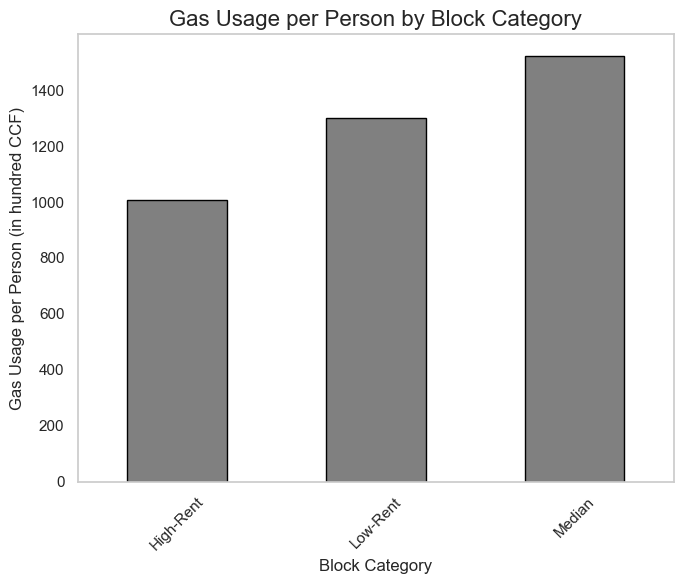

In [23]:
x = gas_usage_and_population['Gas Usage per Person (CCF)']
# sort by Block Category

plt.figure(figsize=(7, 6))
x.plot(kind='bar', color='grey', edgecolor='black')
plt.title('Gas Usage per Person by Block Category', fontsize=16)
plt.xlabel('Block Category')
plt.ylabel('Gas Usage per Person (in hundred CCF)')
plt.xticks(rotation=45)
plt.grid(False)
plt.tight_layout()

# Save as SVG & PNG files
plt.savefig(path_name + 'gas_usage_per_person.svg', format='svg', bbox_inches='tight')
plt.savefig(png_path_name + 'gas_usage_per_person.png', format='png', bbox_inches='tight')

plt.show()

<Figure size 700x600 with 0 Axes>

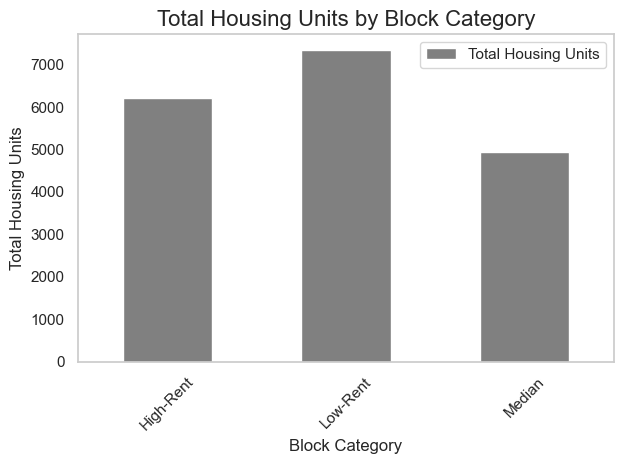

  Block Category  Total Housing Units
0      High-Rent                 6221
1       Low-Rent                 7343
2         Median                 4945


In [24]:
# Total housing units
total_housing_unit = summary_census_data.groupby('Block Category')['Total Housing Units'].sum().reset_index()

plt.figure(figsize=(7, 6))
total_housing_unit.plot(kind='bar', x='Block Category', y='Total Housing Units', color='grey')
plt.title('Total Housing Units by Block Category', fontsize=16)
plt.xlabel('Block Category')
plt.ylabel('Total Housing Units')
plt.xticks(rotation=45)
plt.grid(False)
plt.tight_layout()

# Save as SVG & PNG files
plt.savefig(path_name + 'total_housing_units.svg', format='svg', bbox_inches='tight')
plt.savefig(png_path_name + 'total_housing_units.png', format='png', bbox_inches='tight')

plt.show()

print(total_housing_unit)

## Economic Analysis between three Block category

### Average Income by Block Category

In [25]:
category_order = ['Low-Rent', 'Median', 'High-Rent']
summary_census_data['Block Category'] = pd.Categorical(summary_census_data['Block Category'], categories=category_order, ordered=True)

# Calculate the average median income for each Block Category
average_income = summary_census_data.groupby('Block Category')['Median Income'].mean()

# Print the results in the specified order
print(average_income)


Block Category
Low-Rent     83515.153846
Median       55034.357143
High-Rent    22956.384615
Name: Median Income, dtype: float64


### Dollar unit conversion for total gas usage from CCF to USD

                Total Gas Usage (CCF)
Block Category                       
Low-Rent                    36.193891
Median                      28.136053
High-Rent                   23.915758
Unknown                      0.882635


<Figure size 700x600 with 0 Axes>

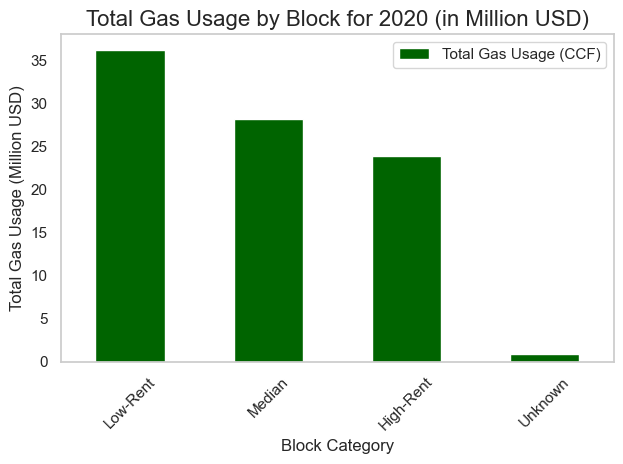

In [26]:
# Dollar unit conversion for total gas usage from CCF to USD
gas_price_per_CCF = 14.72/1000  # Price per CCF in USD
total_gas_usage_by_block_in_dollars = (total_gas_usage_by_block * 100) * gas_price_per_CCF / 1000000  # Convert to million USD
print(total_gas_usage_by_block_in_dollars)


# Plotting the results for total gas usage by block category in dollars (in millions)
plt.figure(figsize=(7, 6))
total_gas_usage_by_block_in_dollars.plot(kind='bar', color='darkgreen')
plt.title('Total Gas Usage by Block for 2020 (in Million USD)', fontsize=16)  # Increased title size
plt.xlabel('Block Category')
plt.ylabel('Total Gas Usage (Million USD)')  # Adjusted label
plt.xticks(rotation=45)
plt.grid(False)  # Remove gridlines
plt.tight_layout()

# Save as SVG & PNG files
plt.savefig(path_name + 'total_gas_usage_by_block_in_dollars.svg', format='svg', bbox_inches='tight')
plt.savefig(png_path_name + 'total_gas_usage_by_block_in_dollars.png', format='png', bbox_inches='tight')

plt.show()

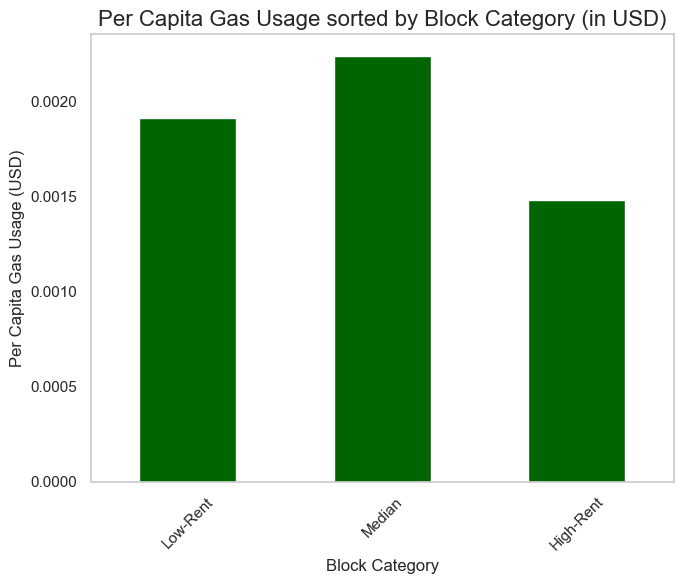

                Total Population  Total Gas Usage (CCF)  \
Block Category                                            
Low-Rent                   18890              36.193891   
Median                     12547              28.136053   
High-Rent                  16149              23.915758   

                Per Capita Gas Usage (USD)  
Block Category                              
Low-Rent                          0.001916  
Median                            0.002242  
High-Rent                         0.001481  


In [27]:
# Assuming summary_census_data is a DataFrame with necessary data
# Total Population by Block Category
population_density = summary_census_data.groupby('Block Category')['Total Population'].sum().reset_index()

# Simulate total_gas_usage_by_block as a DataFrame for demonstration
total_gas_usage_by_block = pd.DataFrame({
    'Block Category': ['Low-Rent', 'Median', 'High-Rent', 'Unknown'],
    'Total Gas Usage (CCF)': [24588241.44, 19114166.52, 16247118.24, 599616.24]
}).set_index('Block Category')


# Merge total gas usage in dollars with population density
total_gas_usage_per_capita = population_density.set_index('Block Category').join(total_gas_usage_by_block_in_dollars)
total_gas_usage_per_capita['Per Capita Gas Usage (USD)'] = total_gas_usage_per_capita['Total Gas Usage (CCF)'] / total_gas_usage_per_capita['Total Population']

# Plotting the results for per capita gas usage by block category in dollars
plt.figure(figsize=(7, 6))
total_gas_usage_per_capita['Per Capita Gas Usage (USD)'].plot(kind='bar', color='darkgreen')
plt.title('Per Capita Gas Usage sorted by Block Category (in USD)', fontsize=16)
plt.xlabel('Block Category')
plt.ylabel('Per Capita Gas Usage (USD)')
plt.xticks(rotation=45)
plt.grid(False)
plt.tight_layout()

# Save as SVG & PNG files
plt.savefig(path_name + 'per_capita_gas_usage.svg', format='svg', bbox_inches='tight')
plt.savefig(png_path_name + 'per_capita_gas_usage.png', format='png', bbox_inches='tight')

plt.show()

print(total_gas_usage_per_capita)

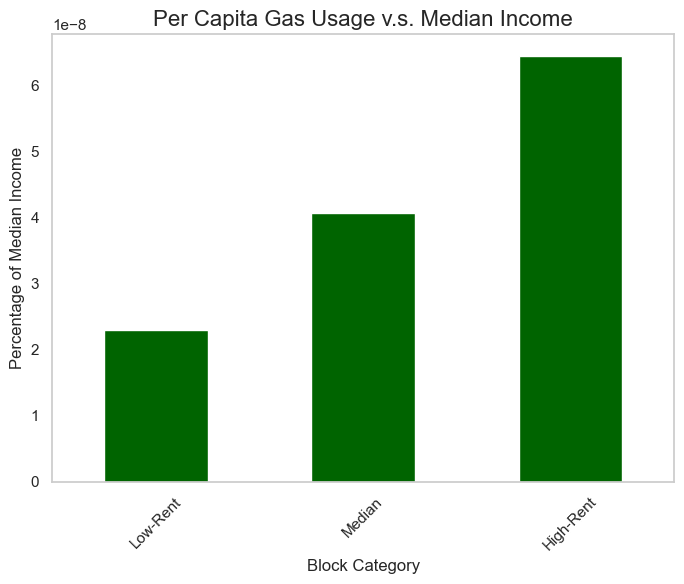

Block Category
Low-Rent     2.294236e-08
Median       4.074641e-08
High-Rent    6.451119e-08
dtype: float64
Block Category
Low-Rent     83515.153846
Median       55034.357143
High-Rent    22956.384615
Name: Median Income, dtype: float64


In [28]:
# Calculate the percentage of median income spent on gas usage
percentage_gas_usage_income = total_gas_usage_per_capita['Per Capita Gas Usage (USD)'] / average_income

# Plotting
plt.figure(figsize=(7, 6))
percentage_gas_usage_income.plot(kind='bar', color='darkgreen')
plt.title('Per Capita Gas Usage v.s. Median Income', fontsize=16)
plt.xlabel('Block Category')
plt.ylabel('Percentage of Median Income')
plt.xticks(rotation=45)
plt.grid(False)
plt.tight_layout()

# Save as SVG & PNG files
plt.savefig(path_name + 'percentage_gas_usage_income.svg', format='svg', bbox_inches='tight')
plt.savefig(png_path_name + 'percentage_gas_usage_income.png', format='png', bbox_inches='tight')

plt.show()

# Print the percentage of income spent on gas
print(percentage_gas_usage_income)

# Print the average income for debug purposes
print(average_income)


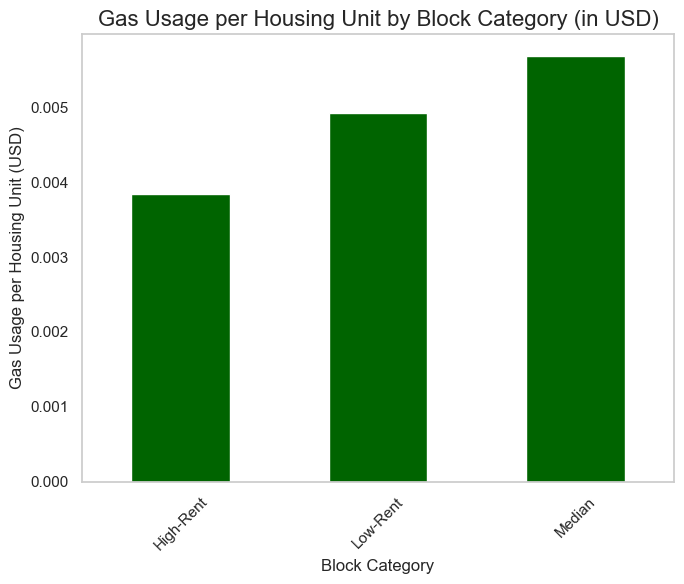

                Total Housing Units  Total Gas Usage (CCF)  \
Block Category                                               
High-Rent                      6221              23.915758   
Low-Rent                       7343              36.193891   
Median                         4945              28.136053   

                Gas Usage per Housing Unit (USD)  
Block Category                                    
High-Rent                               0.003844  
Low-Rent                                0.004929  
Median                                  0.005690  


In [29]:
# Gas Usage by Housing Units
total_gas_usage_per_housing = total_housing_unit.set_index('Block Category').join(total_gas_usage_by_block_in_dollars)
total_gas_usage_per_housing['Gas Usage per Housing Unit (USD)'] = total_gas_usage_per_housing['Total Gas Usage (CCF)'] / total_gas_usage_per_housing['Total Housing Units']

# Plot 
plt.figure(figsize=(7, 6))
total_gas_usage_per_housing['Gas Usage per Housing Unit (USD)'].plot(kind='bar', color='darkgreen')
plt.title('Gas Usage per Housing Unit by Block Category (in USD)', fontsize=16)
plt.xlabel('Block Category')
plt.ylabel('Gas Usage per Housing Unit (USD)')
plt.xticks(rotation=45)
plt.grid(False)
plt.tight_layout()

# Save as SVG & PNG files
plt.savefig(path_name + 'gas_usage_per_housing.svg', format='svg', bbox_inches='tight')
plt.savefig(png_path_name + 'gas_usage_per_housing.png', format='png', bbox_inches='tight')


plt.show()

print(total_gas_usage_per_housing)